In [291]:

import numpy as np
import pandas as pd
import geopandas as gpd
import netCDF4 as nc
import rasterio

from tqdm import tqdm
from netCDF4 import num2date

import matplotlib.pyplot as plt

from shapely.geometry import Point
# from shapely.validation import make_valid

import platform

### Read NC data

In [292]:
nc_data = nc.Dataset("./data/nc/rhum.day.ltm.nc")

In [293]:
print(nc_data)
# print(nc_data.variables.keys())

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4_CLASSIC data model, file format HDF5):
    Conventions: COARDS
    title: mean daily NMC reanalysis
    description: Data is from NMC initialized reanalysis
(4x/day).  It consists of most variables interpolated to
pressure surfaces from model (sigma) surfaces.
    platform: Model
    history: Created 2021/07/26 by doDayLTMNC4
    dataset_title: NCEP-NCAR Reanalysis 1
    References: http://www.psl.noaa.gov/data/gridded/data.ncep.reanalysis.html
    not_missing_threshold_percent: minimum 3% values input to have non-missing output value
    dimensions(sizes): lon(144), lat(73), level(8), time(365), nbnds(2)
    variables(dimensions): float32 lat(lat), float32 lon(lon), float32 level(level), float64 time(time), float64 climatology_bounds(time, nbnds), float32 rhum(time, level, lat, lon), int16 valid_yr_count(time, level, lat, lon)
    groups: 


In [294]:
for temp_value in nc_data.variables.values():
    print("*" * 70, '\n')
    # print(f"variable name: {temp_value.name}, variable shape: {temp_value.shape}")
    print(temp_value)

********************************************************************** 

<class 'netCDF4._netCDF4.Variable'>
float32 lat(lat)
    units: degrees_north
    actual_range: [ 90. -90.]
    long_name: Latitude
    standard_name: latitude
    axis: Y
unlimited dimensions: 
current shape = (73,)
filling on, default _FillValue of 9.969209968386869e+36 used
********************************************************************** 

<class 'netCDF4._netCDF4.Variable'>
float32 lon(lon)
    units: degrees_east
    long_name: Longitude
    actual_range: [  0.  357.5]
    standard_name: longitude
    axis: X
unlimited dimensions: 
current shape = (144,)
filling on, default _FillValue of 9.969209968386869e+36 used
********************************************************************** 

<class 'netCDF4._netCDF4.Variable'>
float32 level(level)
    units: millibar
    actual_range: [1000.  300.]
    long_name: Level
    positive: down
    GRIB_id: 100
    GRIB_name: hPa
    axis: Z
unlimited dimensions: 
c

In [295]:
time_var = nc_data.variables['time']
time_units = time_var.units
# [pd.to_datetime(str(num2date(temp_time,units=time_units))) for temp_time in np.array(nc_data.variables['time'])]
time_list = [num2date(temp_time, units=time_units).strftime('%Y-%m-%d') for temp_time in
             np.array(nc_data.variables['time'])]

In [296]:
# print(time_list)

### Process NC data

In [297]:
process_data = np.array(nc_data.variables['rhum'])  # (time, lat, lon)
# replace missing value  
invalid_value = nc_data.variables['rhum'].missing_value
process_data[process_data == invalid_value] = np.nan

process_data.shape

(365, 8, 73, 144)

In [298]:
(time, level, lat, lon) = process_data.shape

In [299]:
# slices = [process_data[i, :, :] for i in range(time)] 

slice_level = 0
slice_day = '0001-08-13'
time_index = np.where([i == slice_day for i in time_list])[0][0]

rhum_level_data = process_data[:, slice_level, :, :]
rhum_data = process_data[time_index, slice_level, :, :]

print(rhum_data.shape)


(73, 144)


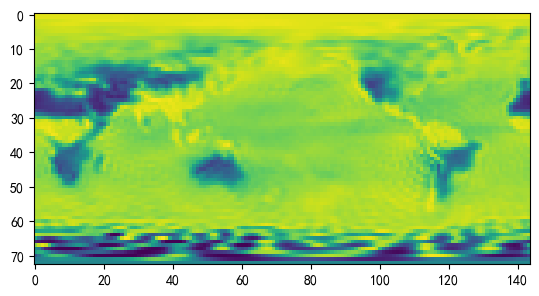

In [300]:
fig, ax = plt.subplots()
ax.imshow(rhum_data)

In [301]:
# time-average 
# specific_level = 0
# result_data = np.zeros(shape=(lat, lon))
# result_data[:, :] = process_data[:, specific_level, :, :].mean(axis=0)

# print(f"result data shape: {result_data.shape}")

In [302]:
lat_data = np.array(nc_data.variables['lat'])  # degrees_north
lon_data = np.array(nc_data.variables['lon'])  # degrees_east
Lon_data, Lat_data = np.meshgrid(lon_data, lat_data)

print(Lon_data.shape, Lat_data.shape)

(73, 144) (73, 144)


Using matplotlib backend: module://matplotlib_inline.backend_inline


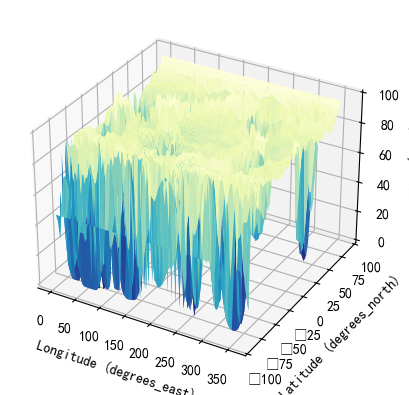

In [303]:

%matplotlib
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

ax.plot_surface(Lon_data, Lat_data,rhum_data, cmap=plt.cm.YlGnBu_r)

ax.set_xlabel(r'Longitude (degrees_east)')
ax.set_ylabel(r'Latitude (degrees_north)')
ax.set_zlabel(r'mean (degK)')

plt.show()

In [304]:
rhum_data_with_location = pd.DataFrame({'lon': Lon_data.flatten(),
                                        'lat': Lat_data.flatten(),
                                        'rhum': rhum_data.flatten()})
rhum_data_with_location.head()

,lon,lat,rhum
0,0.0,90.0,95.69368
1,2.5,90.0,95.69368
2,5.0,90.0,95.69368
3,7.5,90.0,95.69368
4,10.0,90.0,95.69368


### Read JSON data

In [305]:

map_data = gpd.read_file(filename="./data/json/100000_full.json")
# map_data.head()

Skipping field center: unsupported OGR type: 3
Skipping field centroid: unsupported OGR type: 3
Skipping field acroutes: unsupported OGR type: 1


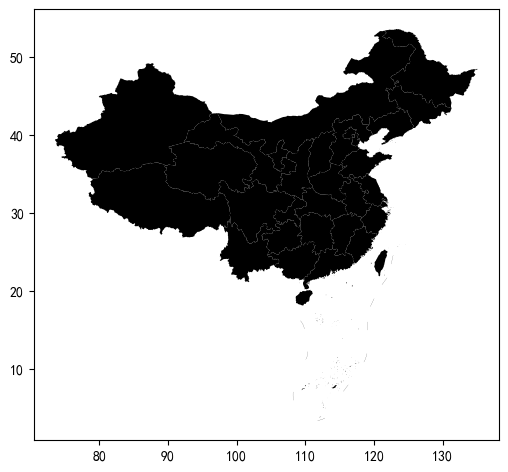

In [306]:
# % matplotlib
fig, ax = plt.subplots(figsize=(6, 6))
map_data.iloc[:35, :].plot(ax=ax, color='black')
plt.show()

In [ ]:
# check if the point in the polygon
# map_data.loc[map_data['name']=='安徽省','geometry'].contains(Point(117.2, 30.7))

11    True
dtype: bool

### Regional average of original data

In [308]:
map_value = map_data[['adcode', 'name', 'geometry']].copy()
map_value['rhum_value'] = 0
map_value['num'] = 0

# map_value.head()

In [309]:

def trans(lon):
    if lon <= 180:
        return lon
    else:
        return lon - 360

# to make all the location data valid
# https://stackoverflow.com/questions/63955752/topologicalerror-the-operation-geosintersection-r-could-not-be-performed
map_value['geometry'] = map_value.buffer(0) #['geometry'].apply(lambda x: make_valid(x))

# 在 GeoDataFrame 中筛选无效几何对象（如自相交、重复点、方向错误的多边形等）。
# 适用于 geopandas 处理空间数据时的数据清洗，可用于检查数据质量。
map_value.loc[~map_value.is_valid]

,adcode,name,geometry,rhum_value,num


In [ ]:
# 
for index in tqdm(range(rhum_data_with_location.shape[0])):
    temp_df = rhum_data_with_location.iloc[index, :]
    temp_mask = map_value['geometry'].contains(Point(trans(temp_df.lon), temp_df.lat))
    # ignore nan value 
    map_value['rhum_value'] += temp_mask * np.nan_to_num(temp_df.rhum, nan=0) 
    map_value['num'] += temp_mask * 1

100%|██████████| 10512/10512 [00:06<00:00, 1540.96it/s]


In [316]:
map_value['mean_rhum'] = map_value['rhum_value'] / map_value['num']  #(map_value['num'] + 0.00001)

map_value.loc[pd.isna(map_value['mean_rhum']), 'mean_rhum'] = 0
map_value.head()

,adcode,name,geometry,rhum_value,num,mean_rhum,center_lon,center_lat
0,110000,北京市,"POLYGON ((115.72253 39.5442, 115.72068 39.5511...",0.000000,0,0.000000,116.419926,40.188020
1,120000,天津市,"POLYGON ((116.91253 39.1109, 116.90945 39.1508...",143.136688,2,71.568344,117.347635,39.284229
2,130000,河北省,"MULTIPOLYGON (((115.72253 39.5442, 115.72253 3...",422.776047,6,70.462674,116.149009,39.546671
3,140000,山西省,"POLYGON ((110.37926 34.60061, 110.29549 34.610...",298.423370,4,74.605843,112.295479,37.572346
4,150000,内蒙古自治区,"POLYGON ((97.1729 42.79526, 97.28254 42.78208,...",2017.252224,40,50.431306,113.926033,44.089916


C:\Users\User\AppData\Local\Temp\ipykernel_24120\316348800.py:18: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  map_value['center_lon'] = map_value['geometry'].centroid.x
C:\Users\User\AppData\Local\Temp\ipykernel_24120\316348800.py:19: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  map_value['center_lat'] = map_value['geometry'].centroid.y


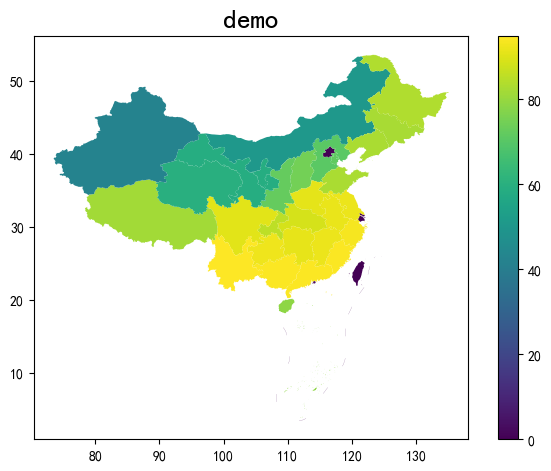

In [317]:
# 检测系统
import platform

if platform.system() == 'Darwin':
    plt.rcParams["font.family"] = 'Arial Unicode MS'
elif platform.system() == 'Windows':
    plt.rcParams["font.family"] = 'SimHei'
else:
    pass
# Linux
# Windows


fig, ax = plt.subplots()

map_value.plot(ax=ax, column='mean_rhum', legend=True)

map_value['center_lon'] = map_value['geometry'].centroid.x
map_value['center_lat'] = map_value['geometry'].centroid.y

for index in range(map_value.shape[0]):
    # ax.scatter(map_value['center_lon'], map_value['center_lat'])
    temp_df = map_value.iloc[index, :]
    # show name
    # ax.text(x=temp_df.center_lon, y=temp_df.center_lat, s=str(temp_df['name']))

ax.set_title("demo", fontdict={"size": 20})
ax.autoscale()
plt.tight_layout()

### Save as Tiff 

In [313]:

# filename = f"./data/tiff/rhum_mean_{slice_level}_{slice_day}.tif"
# with rasterio.open(filename, 'w', driver='GTiff',
#                        height=rhum_data.shape[0], width=rhum_data.shape[1],
#                        count=1, dtype=str(rhum_data.dtype)) as f:
#         f.write(rhum_data, 1)

In [314]:
filename = f"./data/tiff/rhum_mean_{slice_level}_{slice_day}.tif"

def save_as_tiff(filename, array):
    """
    将一个矩阵保存为tiff文件,
    这里还可以设置tiff的crs和transofrm。更多，可以查看rasterio的官网或者下面的这个链接
    https://gis.stackexchange.com/questions/279953/numpy-array-to-gtiff-using-rasterio-without-source-raster
    :param array: shape:(row, col)
    :param filename:
    :return:
    """
    with rasterio.open(filename, 'w', driver='GTiff',
                          height=array.shape[0], width=array.shape[1],
                          count=1, dtype=str(array.dtype)) as f:
            f.write(array, 1)
            